In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import json
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
#from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Flatten, GlobalAveragePooling2D, Concatenate, Dropout, BatchNormalization, concatenate
from tensorflow.keras.utils import Sequence,to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
df_business = pd.read_csv('/content/drive/MyDrive/Yelp-Photos/Yelp Photos/yelp_photos/yelp_academic_dataset_business.csv')
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [5]:
photo_path = "/content/drive/MyDrive/Yelp-Photos/Yelp Photos/yelp_photos/photos.json"
photos_df = pd.read_json(photo_path, lines=True)
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


#Loading the model

In [49]:
model_path = '/content/drive/My Drive/model/efficientnet_finetune.keras'


In [37]:
if os.path.exists('/content/drive/My Drive/model/efficientnet_finetune.keras'):
  print(True)
else:
  print(False)

True


In [38]:
from tensorflow.keras.models import load_model

model = load_model(model_path)



## 🔁 **Round 1: Empirical Tuning of EfficientNet-based Multimodal Model**

In the initial model setup, we used an EfficientNetB0 image backbone with frozen layers, combined with a dense metadata branch. The architecture included moderate regularization through dropout and L2 penalties, and training was done with a relatively high learning rate (`1e-3`). However, the model showed signs of overfitting — training accuracy kept increasing while validation accuracy plateaued and validation loss started rising after a few epochs.

### ✨ Modifications in Round 1

To improve generalization and reduce overfitting, we performed the following empirical tuning:

| Component          | Previous Setting | Tuned Setting | Reason                             |
| ------------------ | ---------------- | ------------- | ---------------------------------- |
| Dropout (image)    | `0.4`            | `0.5`         | Increase regularization            |
| Dropout (metadata) | `0.3`            | `0.5`         | Increase regularization            |
| Dropout (final)    | `0.5`            | `0.6`         | Stronger regularization in fusion  |
| L2 regularization  | `0.001`          | `0.0005`      | Avoid overly aggressive constraint |
| Learning Rate      | `1e-3`           | `5e-4`        | Allow more stable optimization     |
| EarlyStopping      | `patience=2`     | `patience=3`  | Prevent premature termination      |

### 🏗 Updated Architecture Summary

* **Image Branch**: EfficientNetB0 (frozen), followed by Global Average Pooling, BatchNorm, and increased dropout.
* **Metadata Branch**: Dense layer with BatchNorm and higher dropout.
* **Fusion Layer**: Concatenation of both branches, followed by L2-regularized dense layer, higher dropout, and BatchNorm.
* **Output Layer**: Dense layer with softmax for multi-class classification.

### 🧠 Callbacks

* **EarlyStopping**: With higher patience (3 epochs)
* **ReduceLROnPlateau**: Reduces learning rate if validation loss plateaus
* **ModelCheckpoint**: Saves best model based on validation loss

---

### 🎯 Objective

This round of tuning aims to:

* Reduce the model’s tendency to overfit
* Allow more stable convergence by reducing learning rate
* Apply stronger regularization for better generalization to unseen data




In [58]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# EfficientNet base model
image_input = Input(shape=(224, 224, 3), name='image_input')
base_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights='imagenet')


In [59]:

# Freeze all layers initially
base_model.trainable = False

# Image branch
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout

# Metadata branch
meta_input = Input(shape=(metadata_dim,), name='meta_input')
m = Dense(512, activation='relu')(meta_input)
m = BatchNormalization()(m)
m = Dropout(0.5)(m)  # Increased dropout

# Merge branches
combined = Concatenate()([x, m])
z = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(combined)  # Less aggressive L2
z = Dropout(0.6)(z)  # More dropout on combined rep
z = BatchNormalization()(z)

output = Dense(len(label_encoder.classes_), activation='softmax')(z)

# Final model
model = Model(inputs=[image_input, meta_input], outputs=output)

# Compile with reduced LR
model.compile(optimizer=Adam(learning_rate=5e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Updated callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('effnet_tuned_round1.keras', save_best_only=True, monitor='val_loss')

# Fit the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 958s 24s/step - accuracy: 0.2254 - loss: 2.4527 - val_accuracy: 0.2315 - val_loss: 1.8286 - learning_rate: 5.0000e-04
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.2773 - loss: 2.1908 - val_accuracy: 0.2006 - val_loss: 1.8215 - learning_rate: 5.0000e-04
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3111 - loss: 2.0664 - val_accuracy: 0.2018 - val_loss: 1.8217 - learning_rate: 5.0000e-04
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3159 - loss: 2.0164 - val_accuracy: 0.2083 - val_loss: 1.8113 - learning_rate: 5.0000e-04
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3448 - loss: 1.9397 - val_accuracy: 0.2107 - val_loss: 1.8062 - learning_rate: 5.0000e-04
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3571 - loss: 1.9073 - val_accuracy: 0.2464 - val_loss: 1.7835 - learning_rate: 5.0000e-04
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3439 - los

## Loss and Accuracy on Validation Set

In [60]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 629ms/step - accuracy: 0.3655 - loss: 1.6890
Validation Accuracy: 0.3554
Validation Loss: 1.7100


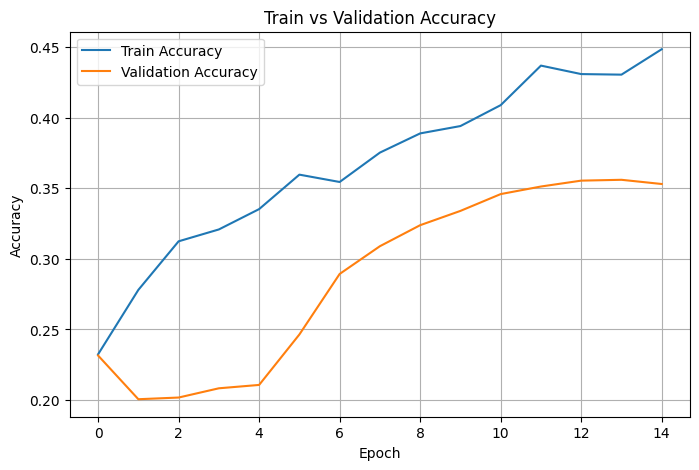

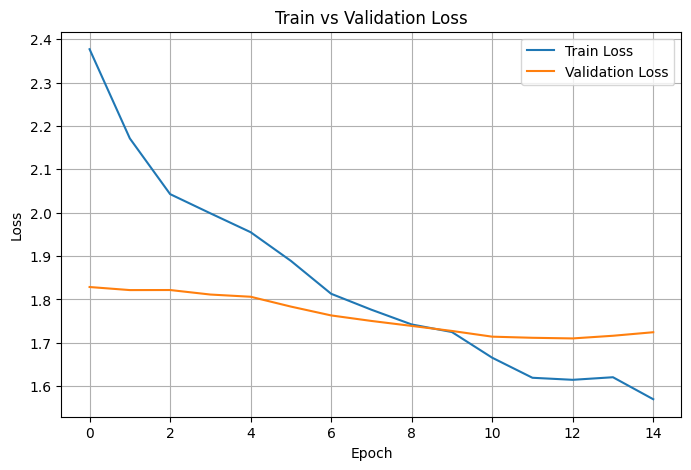

In [65]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#🔁 Round 2

| Component           | Round 1                | Round 2                              |
| ------------------- | ---------------------- | ------------------------------------ |
| EfficientNet layers | All frozen             | Top 50 layers **unfrozen**           |
| Learning rate       | `5e-4`                 | **`1e-5`**                           |
| Training objective  | Transfer learning only | Transfer + task-specific fine-tuning |
| Rest (Dropout, L2)  | Same                   | Same                                 |


In [66]:
# Unfreeze top 50 EfficientNet layers
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# (Re)define callbacks if needed
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('effnet_finetuned_round2.keras', save_best_only=True, monitor='val_loss')

# Continue training
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.3770 - loss: 1.7561 - val_accuracy: 0.3101 - val_loss: 1.8649 - learning_rate: 1.0000e-05
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3984 - loss: 1.6775 - val_accuracy: 0.2905 - val_loss: 2.0239 - learning_rate: 1.0000e-05
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.4064 - loss: 1.6700
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4065 - loss: 1.6697 - val_accuracy: 0.2917 - val_loss: 2.0872 - learning_rate: 1.0000e-05
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3934 - loss: 1.7022 - val_accuracy: 0.2905 - val_loss: 2.0670 - learning_rate: 2.0000e-06


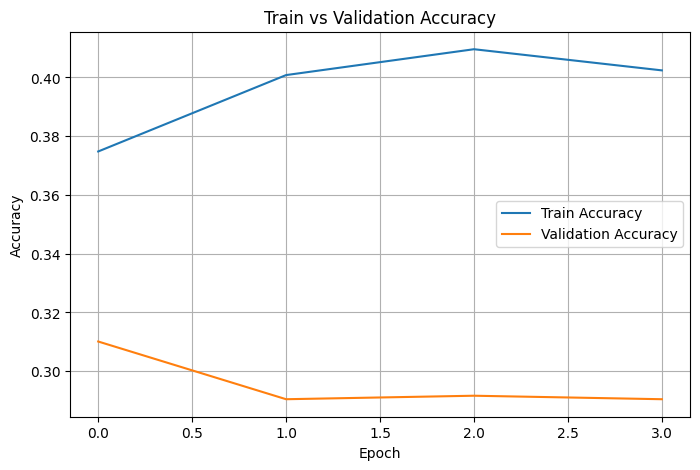

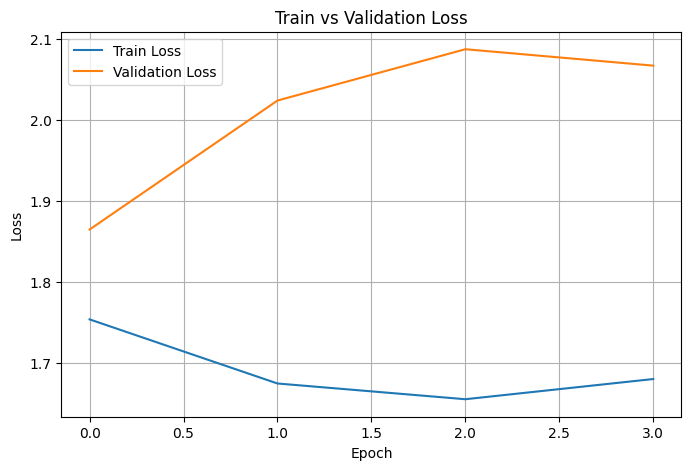

In [68]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#3 Fewer Layers + Train Longer + Add Augmentation

In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

# Assuming you have a custom generator or zip images with metadata:
# Example: train_gen = YourCustomGenerator(image_datagen, ...)


In [70]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False


In [71]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Compile with small LR
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('effnet_finetuned_better.keras', save_best_only=True, monitor='val_loss')

# Train longer
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3692 - loss: 1.7348 - val_accuracy: 0.3095 - val_loss: 1.9157 - learning_rate: 1.0000e-05
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3888 - loss: 1.7071 - val_accuracy: 0.3131 - val_loss: 1.9314 - learning_rate: 1.0000e-05
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3810 - loss: 1.7505 - val_accuracy: 0.3119 - val_loss: 1.9364 - learning_rate: 1.0000e-05
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.4032 - loss: 1.6861
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4030 - loss: 1.6862 - val_accuracy: 0.3125 - val_loss: 1.9193 - learning_rate: 1.0000e-05
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3908 - loss: 1.7039 - val_accuracy: 0.3185 - val_loss: 1.8934 - learning_rate: 2.0000e-06
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.3896 - loss: 1

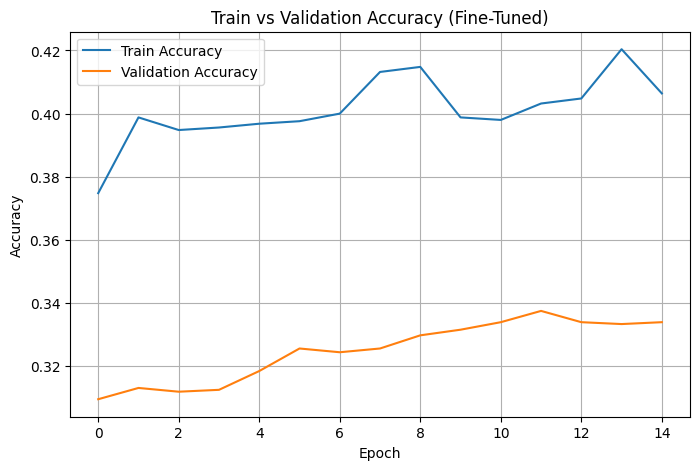

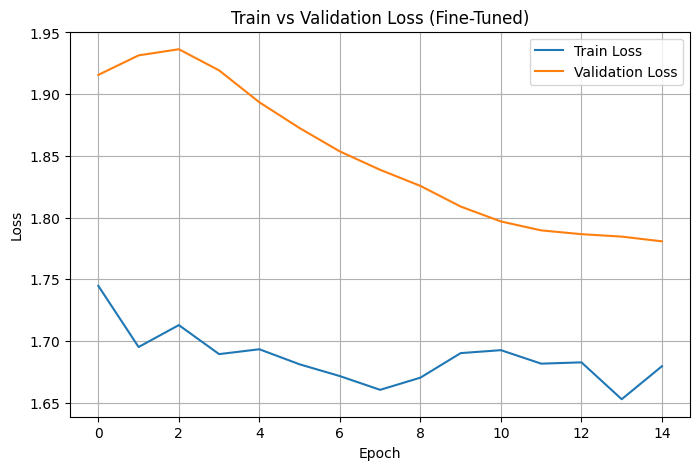

In [72]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy (Fine-Tuned)')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss (Fine-Tuned)')
plt.legend()
plt.grid(True)
plt.show()


#### In Round 2, we fine-tuned the top 20 layers of EfficientNetB0 while maintaining strong regularization. Although this reduced training time and helped with stability, the model’s performance plateaued, likely due to limited feature learning capacity. Validation accuracy improved only modestly (~3%). This suggests that either more layers should be unfrozen or richer metadata modeling is needed.

27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 816ms/step
              precision    recall  f1-score   support

       drink       0.41      0.41      0.41       336
        food       0.29      0.62      0.39       336
      inside       0.31      0.15      0.21       336
        menu       0.43      0.33      0.37       336
     outside       0.28      0.15      0.20       336

    accuracy                           0.33      1680
   macro avg       0.34      0.33      0.32      1680
weighted avg       0.34      0.33      0.32      1680



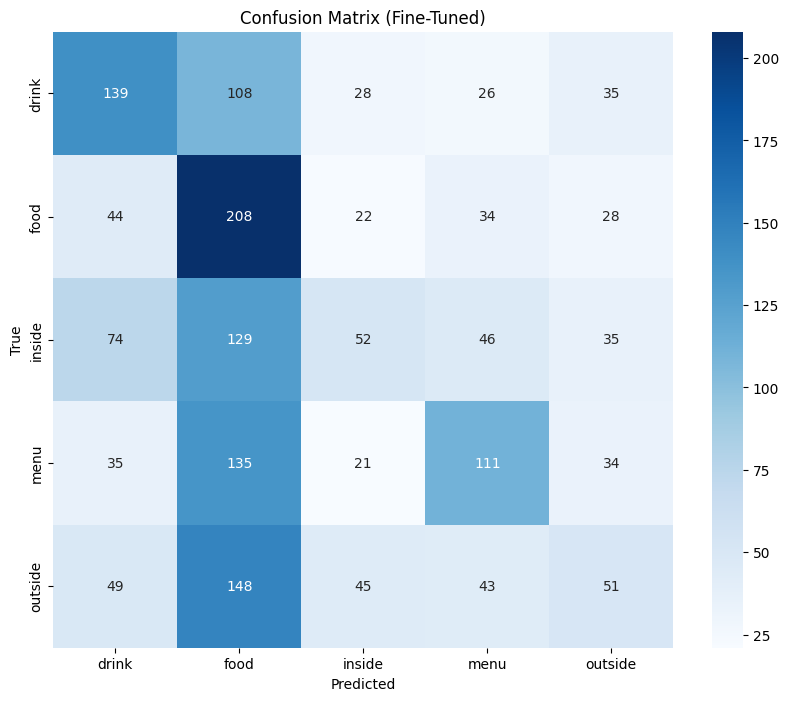

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Collect true and predicted labels
y_true = []
for i in range(len(val_gen)):
    _, y_batch = val_gen[i]
    y_true.extend(y_batch)
y_true = np.array(y_true)

y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Fine-Tuned)")
plt.show()
